In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.687771 -1.259772 -1.292764 -0.237176 -0.342247 -0.534328 -1.008523   
  1   0.086533  0.731217 -0.515702 -0.330738  0.462591  0.685976 -0.515157   
  2  -0.757460 -0.582764 -0.678004 -0.529017  0.177175  0.118711 -0.290119   
  3  -1.174125 -0.783245 -0.271551  0.293677 -0.033494 -0.544116 -0.990432   
  4   0.175419 -0.140874 -0.067493 -0.182765  0.676729  0.662387 -0.517048   
  5  -0.306202 -1.123495 -0.089487 -0.605335  0.712598  0.753903  0.138553   
  6   0.202024 -0.368450 -0.431504  0.269333  0.813421  1.602956 -0.227136   
  7  -0.468683 -0.035719  0.269403  0.131275  0.827514  0.084695 -0.551337   
  8   0.231127 -0.169446 -1.176195 -0.256375  0.628325  0.152860  0.035046   
  9  -0.109175  0.640164  0.003910 -0.608905  0.073065  0.918384 -1.028259   
  10  0.933696 -0.051907  0.510564  0.451071  1.519187  0.775116  0.499134   
  11 -0.605881  0.107311 -0.036569  0.317669 -1.160700  0.226248 -0.133768   
  12 -0.681795 -0.169378  0.496444 -0.057090 -0.719998 -0.583150  0.910799   
  13 -0.670538  0.694823 -0.893260  0.446476  0.889396  0.812659 -0.309720   
  14 -0.187590  0.050583  0.429956  0.449802  0.292838 -0.356330 -0.241567   
  15 -0.293582 -0.559565  0.202393  0.245565 -0.088528 -0.626532 -0.878194   
  16 -0.722363 -0.092543 -0.985938 -0.022940  0.091722  0.919603  0.248630   
  17 -0.475451 -0.117546 -0.304135  0.236333  0.413947  0.574148 -0.619986   
  18  0.677496  0.859132 -0.494230 -0.647894  0.174964 -0.220872  0.127307   
  19  0.023845 -0.245849 -1.027734 -0.699018 -0.856600  0.865992 -0.785792   
  20 -1.278566 -0.320750 -0.296830  0.106739  0.761970 -0.377224  0.141387   
  21 -0.171008 -0.079158  0.891818 -0.168213  0.834184  0.013904  0.067033   
  22  0.206483  0.014986  0.739200 -0.418958  0.429931  0.889762  0.372559   
  23  0.318272  0.577395  0.039567  0.683785  0.783037  0.854107  0.077912   
  24  0.707368 -0.097631  0.128419  0.742719  0.614236 -0.125860 -0.929240   
1 0  -0.759040 -0.418751 -1.106159  0.701232  0.688933 -0.617903 -0.644119   
  1  -1.446213 -0.138169 -0.096480  0.045956  1.477544 -0.150184 -0.123757   
  2  -0.182428  0.721606 -0.284593 -0.571197 -0.103383  0.517300 -0.195699   
  3  -0.181073  0.527187  0.332848 -0.509079  0.471935 -0.081049  0.698462   
  4  -0.613440 -0.213062 -0.035457 -0.455040 -0.784248 -0.900112 -0.751078   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.520443  0.592677 -0.457015  ... -1.089753 -0.987008 -0.563613   
  1  -0.442121 -0.470380  0.440790  ... -0.928851 -0.891145  0.539699   
  2   0.156592 -0.752580 -0.353262  ... -0.977031 -0.567848  0.547440   
  3  -0.302747  0.356963 -0.541576  ...  0.051612 -0.636001 -0.636724   
  4  -0.140454 -1.285008 -1.833830  ... -0.115545 -0.037153  0.359162   
  5   0.061668 -0.623695  0.753386  ...  0.267780 -1.275679 -0.258040   
  6   0.733726  0.328613 -0.139600  ... -0.474387 -0.762907 -0.207326   
  7   0.562845 -0.011727 -0.596073  ...  0.128053  0.518190  0.160579   
  8   0.013576  0.038137  0.472650  ... -0.232021 -0.167096  0.258238   
  9   0.199776  0.775756  0.330926  ... -0.660332  0.037924  0.367176   
  10  0.521091 -0.355900 -0.513985  ...  0.015448 -0.022137 -0.122542   
  11 -0.047589 -1.097414  0.381551  ...  0.062820 -0.716174  0.156928   
  12  0.520371  0.149053  0.291846  ... -0.720337 -0.453380 -0.723969   
  13  0.037414  1.076011 -0.096777  ... -0.195799  0.138505  0.644315   
  14 -0.588656 -0.111823  0.134645  ... -0.300201 -0.256909  0.441729   
  15 -0.055867  0.022224 -0.278093  ... -0.318828 -0.832520  0.159694   
  16 -0.376804 -0.207971 -0.851148  ... -0.593928  0.158164 -0.127979   
  17  1.320194  0.982281 -1.664015  ...  0.500750 -1.725369 -0.037494   
  18  0.951612  0.082219 -0.392716  ...  0.426438 -0.177961 -1.099602   
  19  0.038899 -0.004421 -0.487609  ...  0.742590 -0.330623  0.902590   
  20  0.434796 -0.182402 -0.015871  ...  0.342714 -0.270076 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.017128  0.047324  21.492632  1.824685e-102  0.924373  1.109882


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



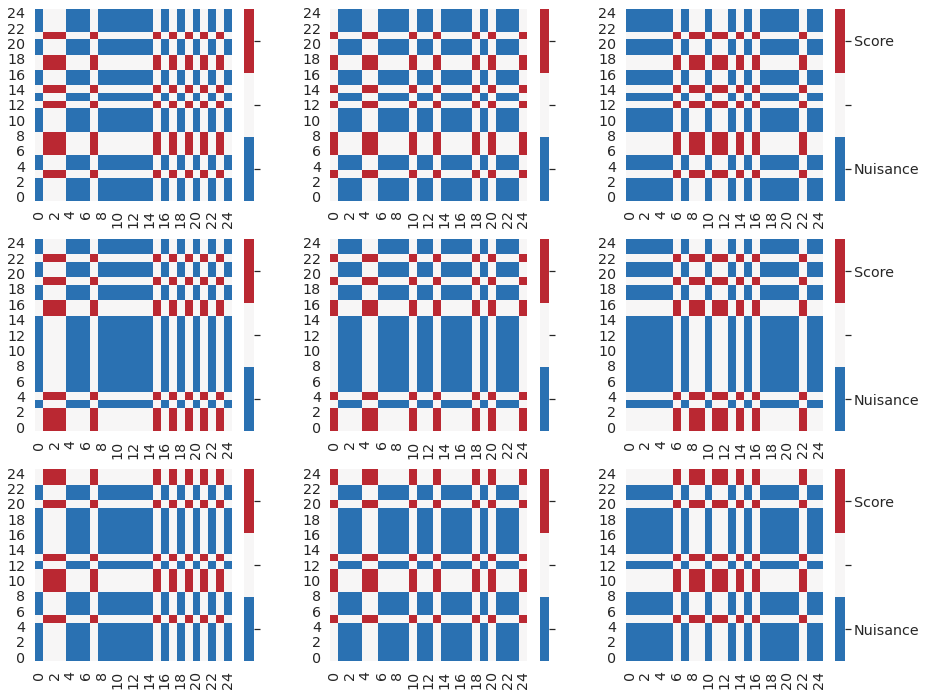

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



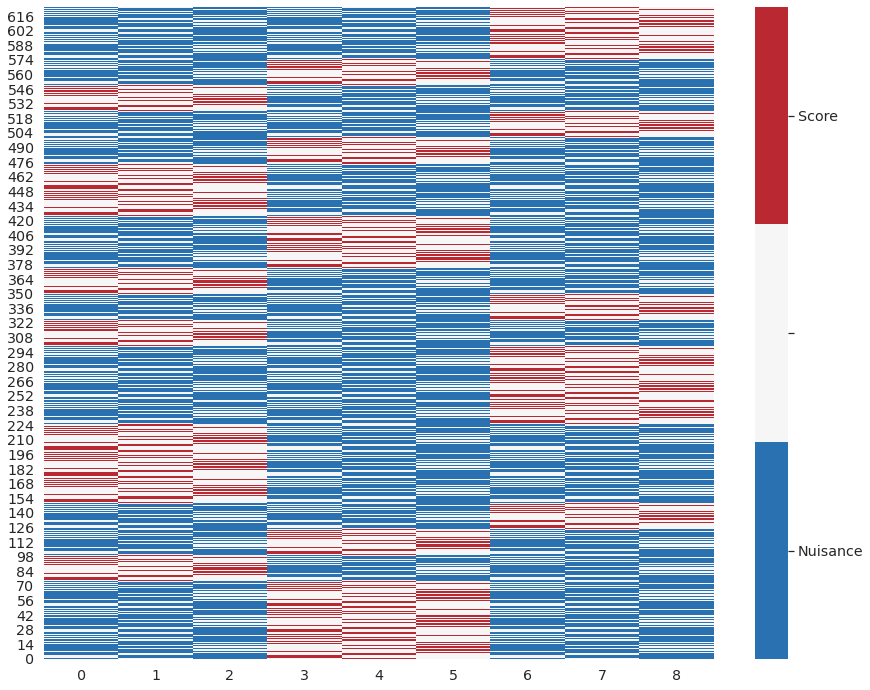

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])